In [1]:
import sys
from collections import defaultdict
from itertools import combinations

import numpy as np
from matplotlib import pyplot as plt

from src.cfd import CFD
from src.dataset import load_expanded_dataset
from src.gauss_hist import plot_gauss_hist
from src.utils import deconvolve_precision, PLANES

PWD = '../..'
sys.path.append(PWD)

IMAGES_DIR = PWD + '/data/images/cfd_deconvolution/'

In [2]:
CFD_THRESHOLD = 0.2
CFD_N_BASELINE = 6

cfd = CFD(n_baseline=CFD_N_BASELINE, threshold=CFD_THRESHOLD)

dataset = load_expanded_dataset(PWD)

# Add t0 to CFD timestamps

In [3]:
cfd_timestamps = {key: dataset.t0[key] + dataset.t_pred[key] for key in dataset.keys()}

# Find mutual precisions

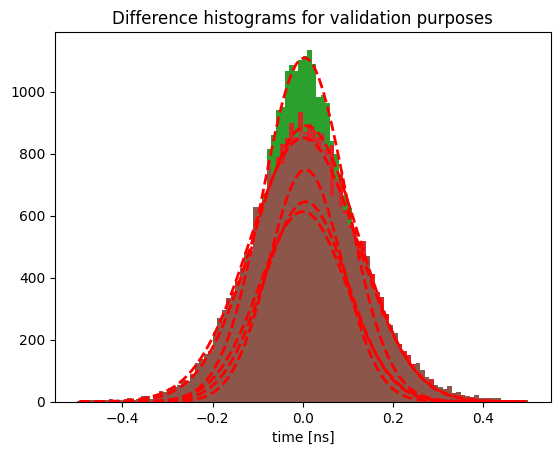

In [4]:
mutual_precisions = {}

for p_ch1, p_ch2 in combinations(cfd_timestamps.keys(), 2):
    if p_ch1[1] == p_ch2[1]:  # Only for corresponding channels
        ch1_timestamps, ch2_timestamps = cfd_timestamps[p_ch1], cfd_timestamps[p_ch2]
        differences = [ch2_t - ch1_t for ch1_t, ch2_t in zip(ch1_timestamps, ch2_timestamps) if
                       not np.isnan(ch1_t) and not np.isnan(ch2_t)]

        _, std, _, _ = plot_gauss_hist(differences, show=False)
        mutual_precisions[(p_ch1, p_ch2)] = np.std(differences)

plt.title("Difference histograms for validation purposes")
plt.show()

In [5]:
channel_mutual_precisions = defaultdict(dict)
for ((x_p, x_ch), (y_p, y_ch)), precision in mutual_precisions.items():
    assert x_ch == y_ch
    channel_mutual_precisions[x_ch][(x_p, y_p)] = precision

In [6]:
for ch, data in channel_mutual_precisions.items():
    for (p_1, p_2), prec in data.items():
        print(f'ch {ch:2}: (p{p_1} vs p{p_2}): {prec:0.3f}')

ch  2: (p1 vs p2): 0.088
ch  2: (p1 vs p3): 0.105
ch  2: (p2 vs p3): 0.110
ch 11: (p1 vs p2): 0.099
ch 11: (p1 vs p3): 0.122
ch 11: (p2 vs p3): 0.129


# Deconvolve

In [7]:
deconvolved_precisions = {}
for ch, prec_dict in channel_mutual_precisions.items():
    for p in PLANES:
        deconvolved_precisions[(p, ch)] = deconvolve_precision(p, prec_dict)

In [8]:
for (p, ch), prec in deconvolved_precisions.items():
    print(f'(p {p}, ch {ch:2}): {prec:0.3f}')

(p 1, ch  2): 0.081
(p 2, ch  2): 0.094
(p 3, ch  2): 0.125
(p 1, ch 11): 0.090
(p 2, ch 11): 0.108
(p 3, ch 11): 0.147
